In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("GRAD-CAM VISUALIZATION FOR FACE CLASSIFICATION MODEL")
print("=" * 80)

GRAD-CAM VISUALIZATION FOR FACE CLASSIFICATION MODEL


In [20]:
CONFIG = {
    'model_path': '/content/best_model.pth',  # Update this path
    'data_dir': '/content/img',
    'output_dir': '/content/results',
    'img_size': 224,
    'num_samples': 20,  # Number of samples to visualize
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print(f"\nUsing device: {CONFIG['device']}")
device = torch.device(CONFIG['device'])


Using device: cuda


In [21]:
class FaceClassifierCNN(nn.Module):
    """Custom CNN for face classification"""

    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(FaceClassifierCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3)
        )

        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4)
        )

        # Convolutional Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4)
        )

        # Convolutional Block 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.5)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [22]:
class GradCAM:
    """Grad-CAM implementation for CNNs"""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        """Hook to save forward pass activations"""
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        """Hook to save backward pass gradients"""
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap"""
        # Forward pass
        self.model.eval()
        output = self.model(input_image)

        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]

        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2))  # [C]

        # Weighted sum of activations
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), target_class


In [23]:
def apply_colormap_on_image(org_im, activation, colormap=cv2.COLORMAP_JET, alpha=0.5):
    """Apply heatmap on original image"""
    # Resize activation to match image size
    h, w = org_im.shape[:2]
    heatmap = cv2.resize(activation, (w, h))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on image
    superimposed = heatmap * alpha + org_im * (1 - alpha)
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)

    return superimposed, heatmap

def visualize_gradcam(original_img, cam, pred_class, true_class, prob,
                      save_path=None, img_name=""):
    """Create comprehensive Grad-CAM visualization"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Convert tensor to numpy for visualization
    if isinstance(original_img, torch.Tensor):
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = original_img.cpu().numpy().transpose(1, 2, 0)
        img_np = std * img_np + mean
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
    else:
        img_np = original_img

    # Generate overlays
    overlay, heatmap = apply_colormap_on_image(img_np, cam, alpha=0.4)
    overlay_strong, _ = apply_colormap_on_image(img_np, cam, alpha=0.6)

    # Plot 1: Original Image
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Plot 2: Heatmap Only
    axes[1].imshow(heatmap)
    axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Plot 3: Overlay (40%)
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (α=0.4)', fontsize=12, fontweight='bold')
    axes[2].axis('off')

    # Plot 4: Overlay (60%)
    axes[3].imshow(overlay_strong)
    axes[3].set_title('Overlay (α=0.6)', fontsize=12, fontweight='bold')
    axes[3].axis('off')

    # Add prediction info
    class_names = ['Real', 'Fake']
    pred_label = class_names[pred_class]
    true_label = class_names[true_class]
    correct = "✓" if pred_class == true_class else "✗"
    color = 'green' if pred_class == true_class else 'red'

    fig.suptitle(
        f'{img_name}\n'
        f'True: {true_label} | Predicted: {pred_label} ({prob:.2%}) {correct}',
        fontsize=14, fontweight='bold', color=color, y=1.02
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    plt.close()

In [24]:
def load_model_weights(model, checkpoint_path, device):
    """Load model weights handling DataParallel wrapper"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Extract state dict
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        epoch = checkpoint.get('epoch', 'N/A')
        val_acc = checkpoint.get('val_acc', 'N/A')
    else:
        state_dict = checkpoint
        epoch = 'N/A'
        val_acc = 'N/A'

    # Remove 'module.' prefix if present (from DataParallel)
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('module.'):
            new_key = key[7:]  # Remove 'module.' prefix
        else:
            new_key = key
        new_state_dict[new_key] = value

    # Load the cleaned state dict
    model.load_state_dict(new_state_dict)

    return model, epoch, val_acc

print("\n" + "=" * 80)
print("LOADING TRAINED MODEL")
print("=" * 80)

# Initialize model
model = FaceClassifierCNN(num_classes=2, dropout_rate=0.5)
model = model.to(device)

# Load trained weights
try:
    model, epoch, val_acc = load_model_weights(model, CONFIG['model_path'], device)
    print(f"✓ Model loaded successfully")
    if epoch != 'N/A':
        print(f"✓ Training epoch: {epoch}")
    if val_acc != 'N/A':
        print(f"✓ Validation accuracy: {val_acc:.2f}%")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please update CONFIG['model_path'] with correct path")
    raise

model.eval()
print("✓ Model set to evaluation mode")


LOADING TRAINED MODEL
✓ Model loaded successfully
✓ Training epoch: 23
✓ Validation accuracy: 94.74%
✓ Model set to evaluation mode


In [25]:
print("\n" + "=" * 80)
print("LOADING TEST IMAGES")
print("=" * 80)

# Data transforms (same as training, without augmentation)
transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Load test images
real_dir = Path(CONFIG['data_dir']) / 'real'
fake_dir = Path(CONFIG['data_dir']) / 'fake'

real_images = list(real_dir.glob('*.jpg'))[:CONFIG['num_samples']//2]
fake_images = list(fake_dir.glob('*.jpg'))[:CONFIG['num_samples']//2]

all_images = real_images + fake_images
all_labels = [0] * len(real_images) + [1] * len(fake_images)

print(f"✓ Loaded {len(real_images)} real images")
print(f"✓ Loaded {len(fake_images)} fake images")
print(f"✓ Total: {len(all_images)} images for visualization")


LOADING TEST IMAGES
✓ Loaded 3 real images
✓ Loaded 3 fake images
✓ Total: 6 images for visualization



GENERATING GRAD-CAM VISUALIZATIONS

Target layer for Grad-CAM: conv5[0] (Conv2d)
Generating visualizations for 6 images...



Processing:   0%|          | 0/6 [00:00<?, ?it/s]

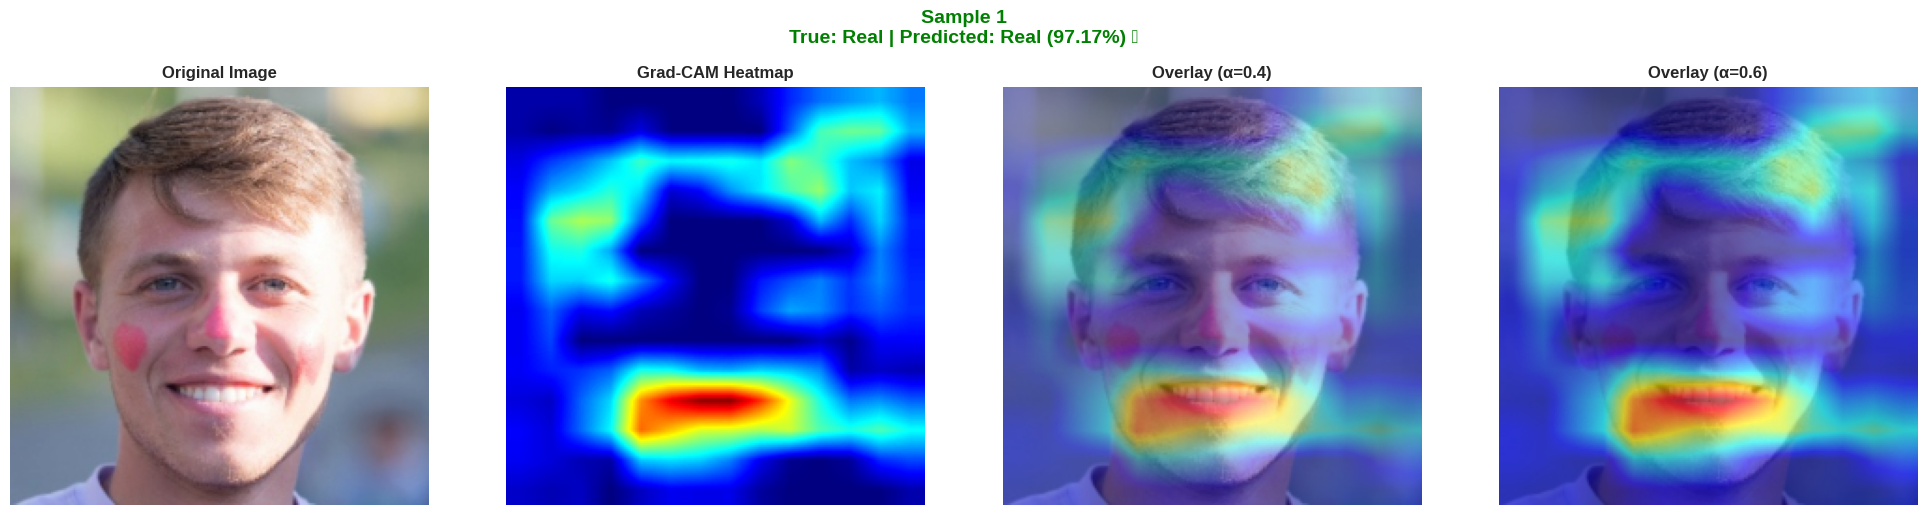

Processing:  17%|█▋        | 1/6 [00:01<00:08,  1.60s/it]

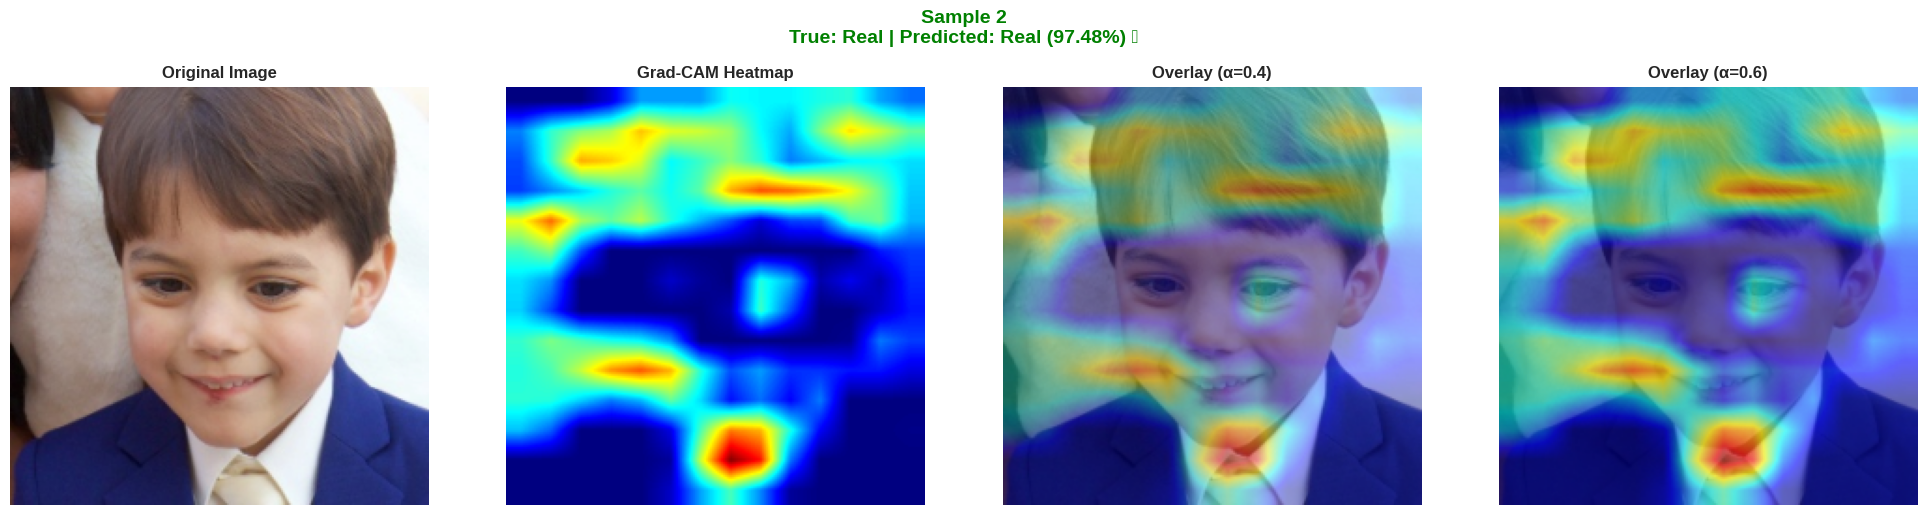

Processing:  33%|███▎      | 2/6 [00:03<00:06,  1.56s/it]

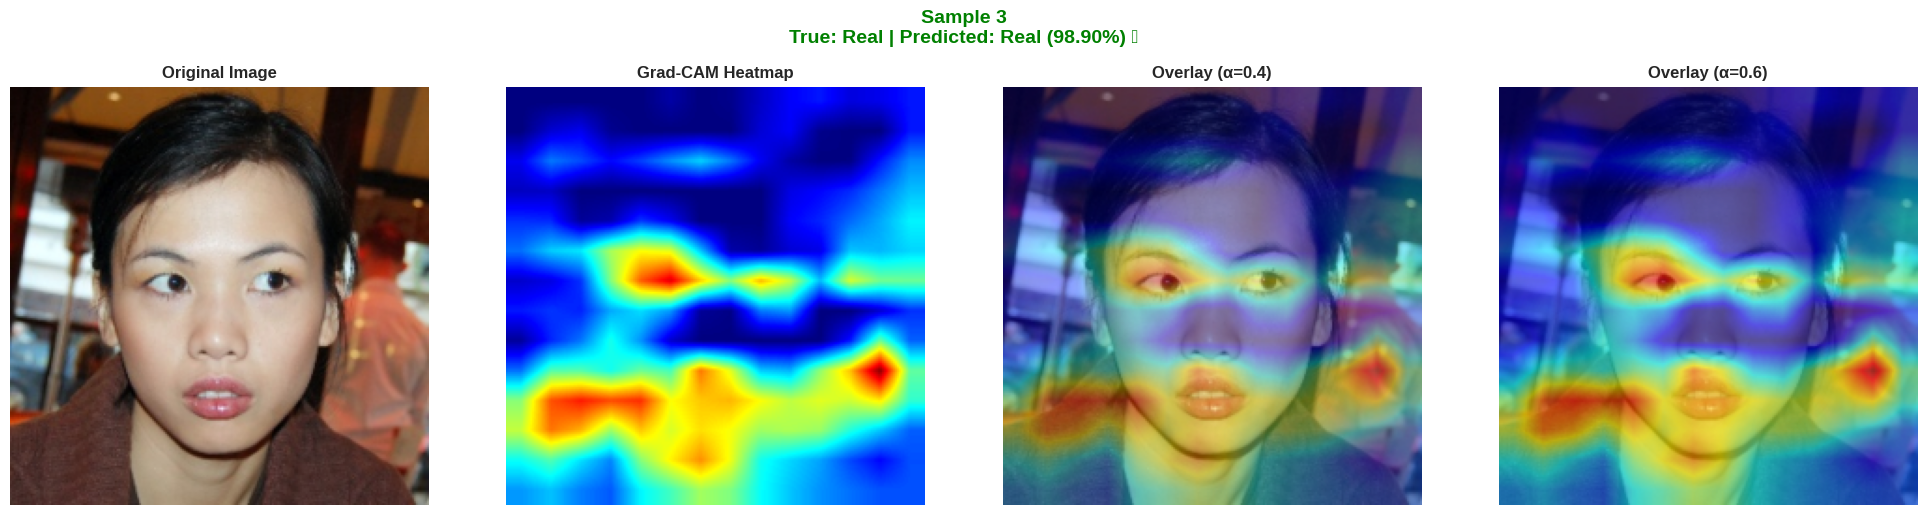

Processing:  50%|█████     | 3/6 [00:04<00:04,  1.57s/it]

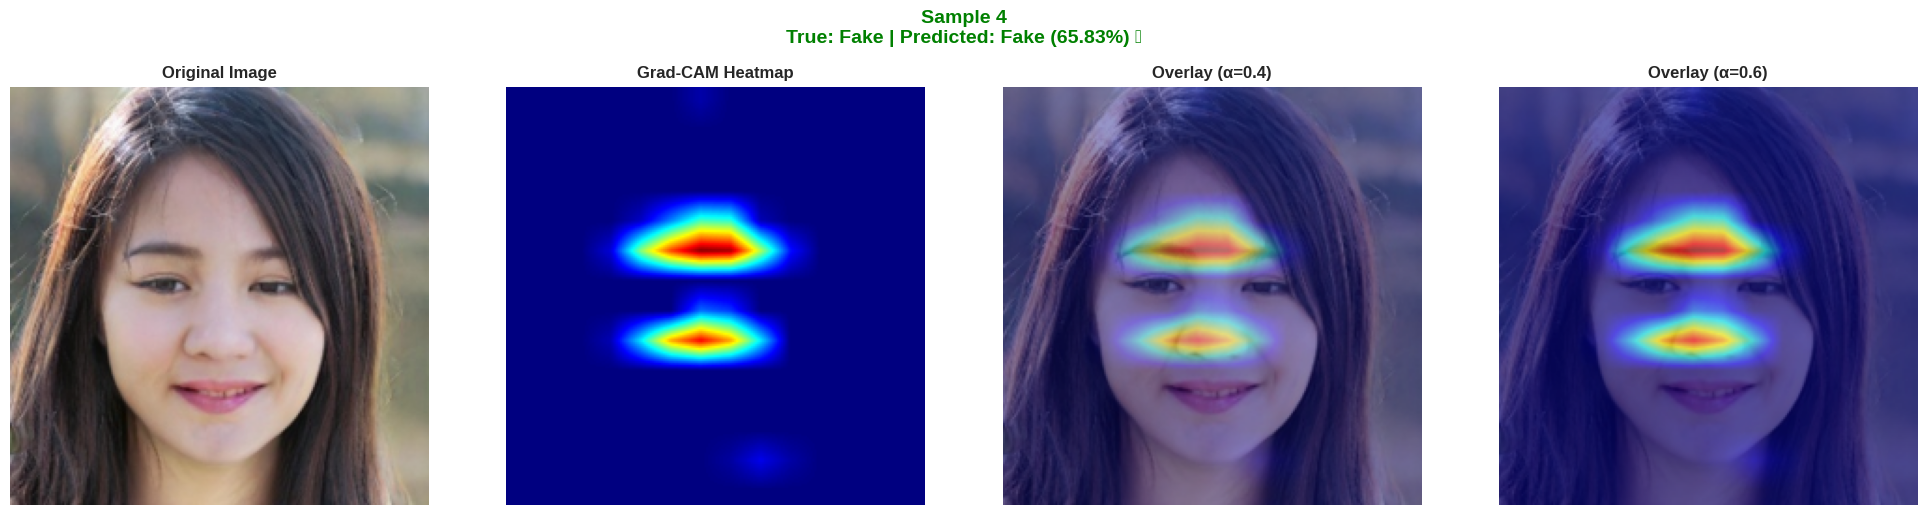

Processing:  67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

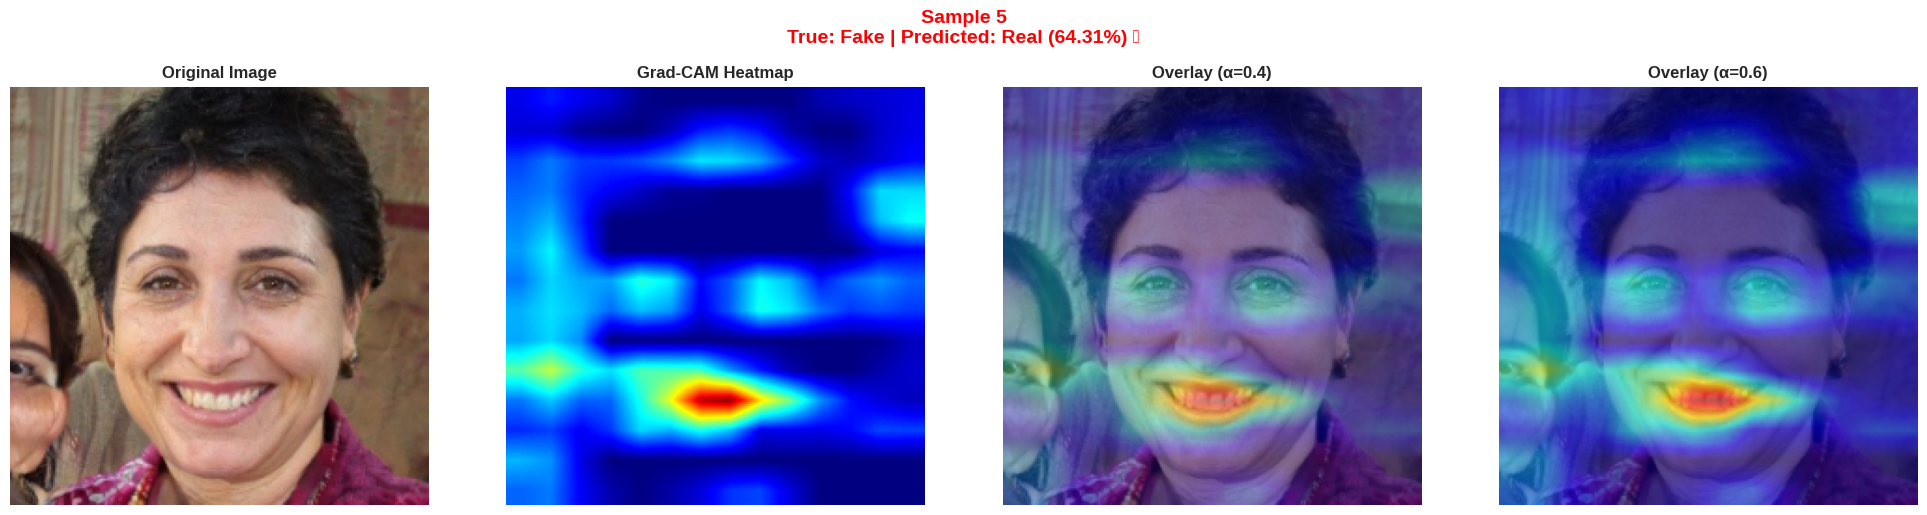

Processing:  83%|████████▎ | 5/6 [00:07<00:01,  1.58s/it]

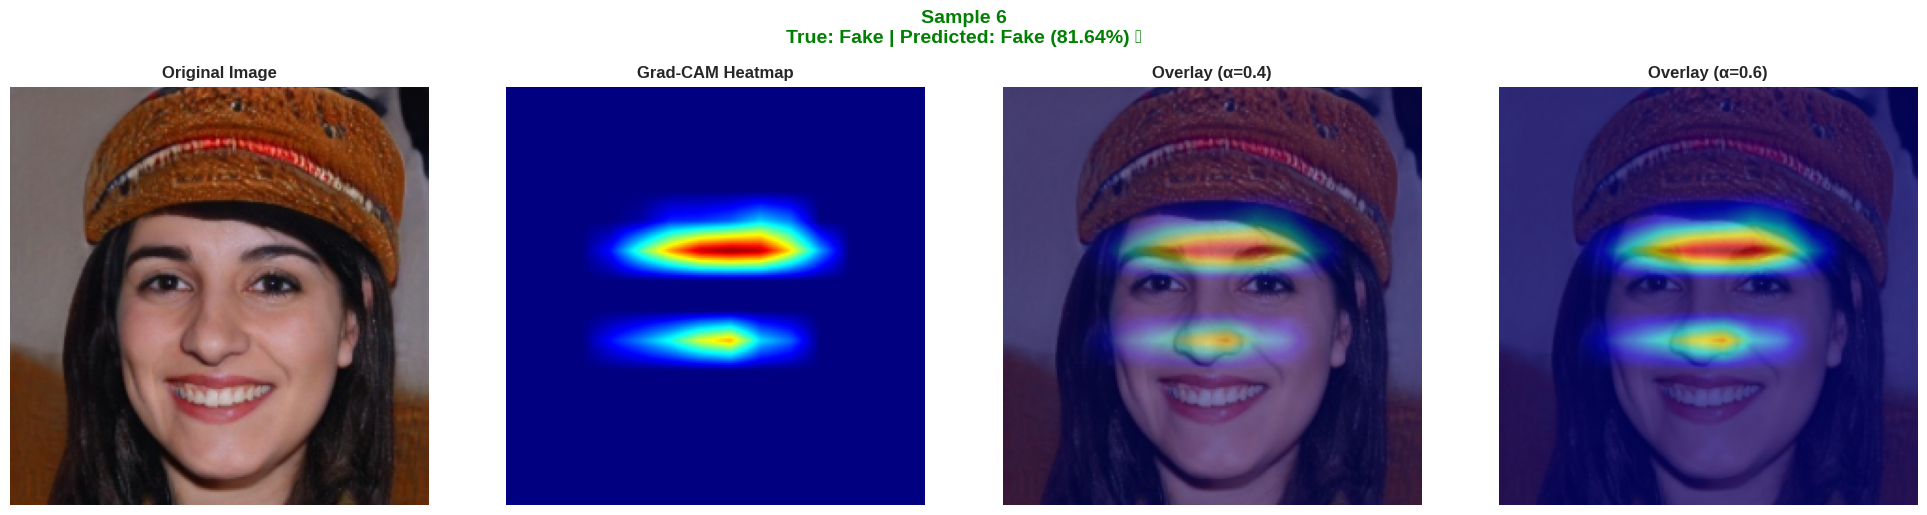

Processing: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


✓ Generated 6 Grad-CAM visualizations
✓ Accuracy on visualized samples: 83.33%
✓ Correct predictions: 5/6


In [26]:
print("\n" + "=" * 80)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("=" * 80)

# Initialize Grad-CAM with last convolutional layer
target_layer = model.conv5[0]  # Last conv layer before pooling
gradcam = GradCAM(model, target_layer)

print(f"\nTarget layer for Grad-CAM: conv5[0] (Conv2d)")
print(f"Generating visualizations for {len(all_images)} images...\n")

# Generate visualizations
correct_count = 0
for idx, (img_path, true_label) in enumerate(tqdm(zip(all_images, all_labels),
                                                   total=len(all_images),
                                                   desc="Processing")):
    # Load and preprocess image
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[0, pred_class].item()

    # Generate Grad-CAM
    cam, _ = gradcam.generate_cam(img_tensor, target_class=pred_class)

    # Track accuracy
    if pred_class == true_label:
        correct_count += 1

    # Create visualization
    img_name = f"Sample {idx+1}"
    save_path = os.path.join(CONFIG['output_dir'], f'gradcam_{idx+1:03d}.png')

    visualize_gradcam(
        img_tensor[0], cam, pred_class, true_label, pred_prob,
        save_path=save_path, img_name=img_name
    )

accuracy = 100 * correct_count / len(all_images)
print(f"\n✓ Generated {len(all_images)} Grad-CAM visualizations")
print(f"✓ Accuracy on visualized samples: {accuracy:.2f}%")
print(f"✓ Correct predictions: {correct_count}/{len(all_images)}")


CREATING SUMMARY GRID


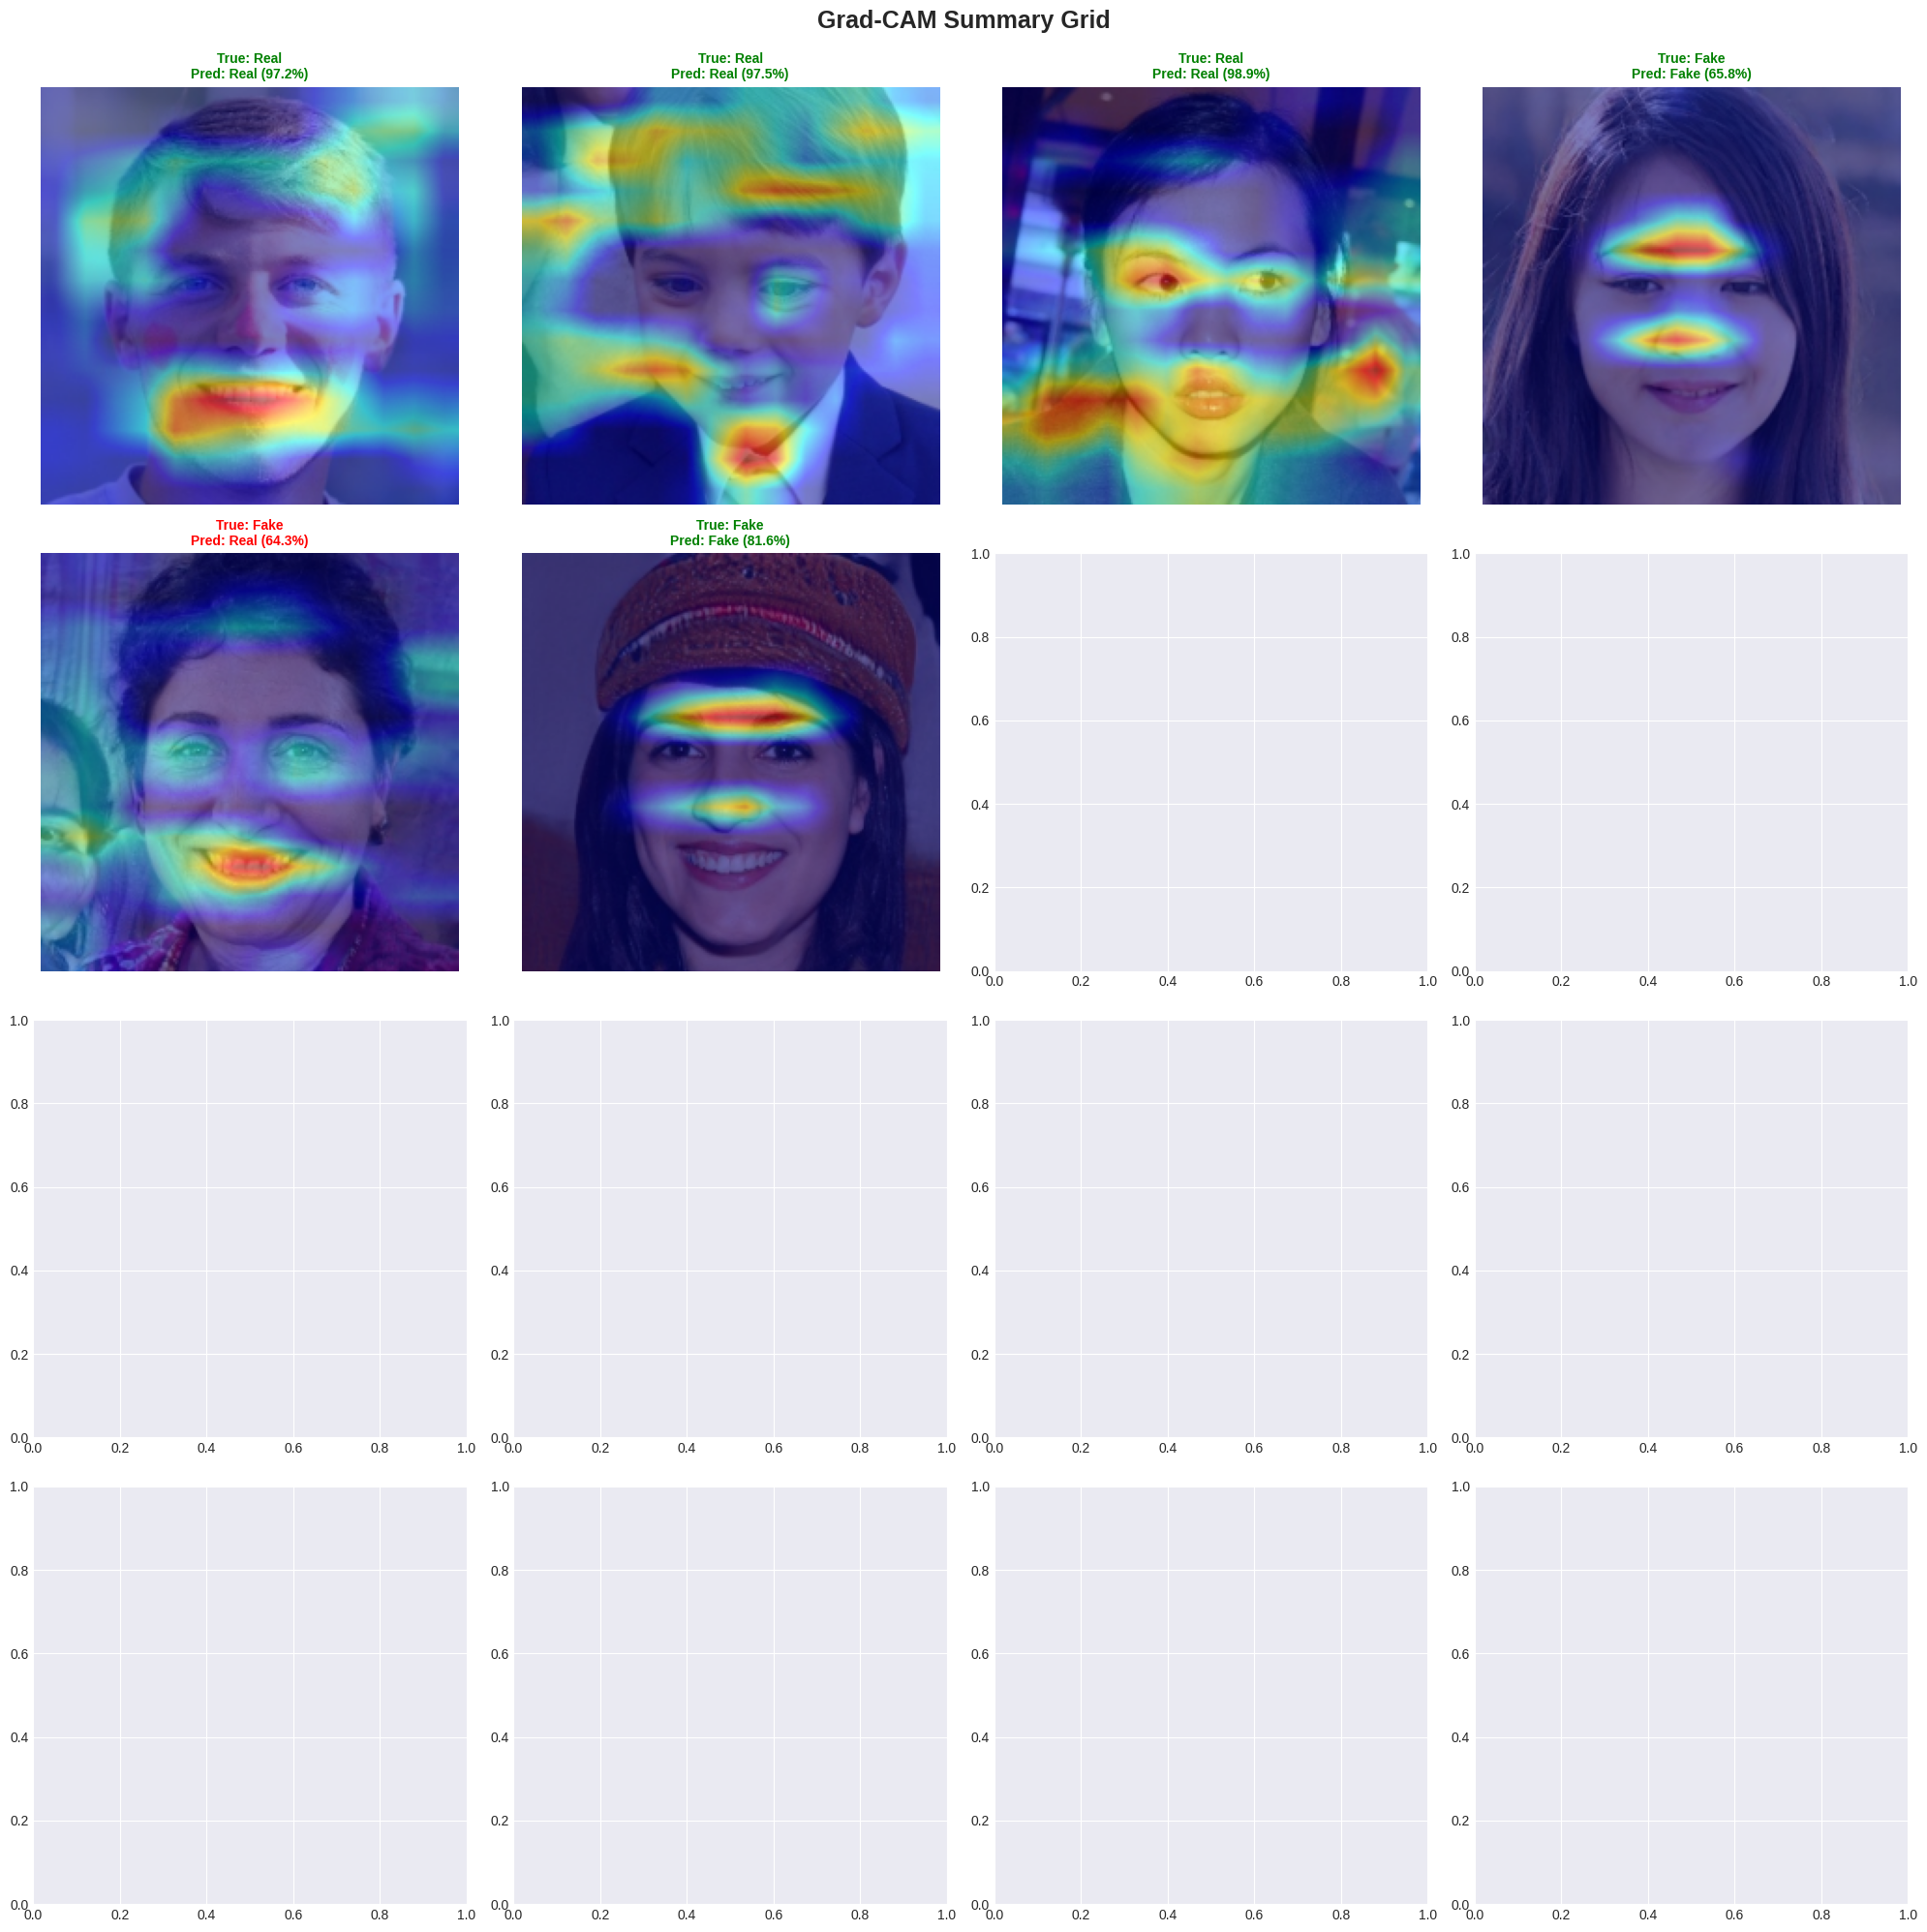

✓ Summary grid saved


In [27]:
print("\n" + "=" * 80)
print("CREATING SUMMARY GRID")
print("=" * 80)

# Select diverse samples (correct and incorrect predictions)
n_grid = min(16, len(all_images))
grid_indices = np.linspace(0, len(all_images)-1, n_grid, dtype=int)

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for idx, ax_idx in enumerate(grid_indices):
    img_path = all_images[ax_idx]
    true_label = all_labels[ax_idx]

    # Load and preprocess
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[0, pred_class].item()

    # Generate Grad-CAM
    cam, _ = gradcam.generate_cam(img_tensor, target_class=pred_class)

    # Prepare image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor[0].cpu().numpy().transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)

    # Create overlay
    overlay, _ = apply_colormap_on_image(img_np, cam, alpha=0.5)

    # Plot
    axes[idx].imshow(overlay)

    # Title with prediction info
    class_names = ['Real', 'Fake']
    color = 'green' if pred_class == true_label else 'red'
    axes[idx].set_title(
        f'True: {class_names[true_label]}\n'
        f'Pred: {class_names[pred_class]} ({pred_prob:.1%})',
        fontsize=10, fontweight='bold', color=color
    )
    axes[idx].axis('off')

plt.suptitle('Grad-CAM Summary Grid', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'gradcam_grid_summary.png'),
            dpi=200, bbox_inches='tight')
plt.show()

print("✓ Summary grid saved")


In [28]:
print("\n" + "=" * 80)
print("GRAD-CAM ANALYSIS REPORT")
print("=" * 80)

report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     GRAD-CAM VISUALIZATION ANALYSIS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. CONFIGURATION
{'=' * 80}
   Model: FaceClassifierCNN (5 conv blocks + 3 FC)
   Target Layer: conv5[0] (Last convolutional layer)
   Image Size: {CONFIG['img_size']}x{CONFIG['img_size']}
   Device: {CONFIG['device']}
   Samples Visualized: {len(all_images)}

2. RESULTS
{'=' * 80}
   Accuracy on Samples: {accuracy:.2f}%
   Correct Predictions: {correct_count}/{len(all_images)}
   Real Images: {len(real_images)}
   Fake Images: {len(fake_images)}

3. INTERPRETATION GUIDE
{'=' * 80}
   What Grad-CAM Shows:
   ├─ Red/Yellow regions: High importance for the model's decision
   ├─ Blue/Purple regions: Low importance for the model's decision
   └─ The heatmap highlights which pixels most influence the prediction

   For Face Classification:
   ├─ Real faces: Model may focus on natural skin texture, symmetry
   ├─ Fake faces: Model may detect artifacts, unnatural smoothness
   └─ Look for: Eyes, nose, mouth, skin texture, image boundaries

4. OUTPUT FILES
{'=' * 80}
   Individual visualizations: {len(all_images)} files (gradcam_001.png to gradcam_{len(all_images):03d}.png)
   Summary grid: gradcam_grid_summary.png
   Location: {CONFIG['output_dir']}

5. NEXT STEPS
{'=' * 80}
   ✓ Analyze attention patterns across correct predictions
   ✓ Study failure cases where model focused on wrong regions
   ✓ Compare attention between real and fake images
   ✓ Use insights to improve model architecture or training

╔══════════════════════════════════════════════════════════════════════════════╗
║                         VISUALIZATION COMPLETED                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(report)

# Save report
with open(os.path.join(CONFIG['output_dir'], 'gradcam_report.txt'), 'w') as f:
    f.write(report)

print(f"\n✓ All outputs saved to: {CONFIG['output_dir']}")
print("✓ Grad-CAM visualization completed successfully! 🎉")


GRAD-CAM ANALYSIS REPORT

╔══════════════════════════════════════════════════════════════════════════════╗
║                     GRAD-CAM VISUALIZATION ANALYSIS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. CONFIGURATION
   Model: FaceClassifierCNN (5 conv blocks + 3 FC)
   Target Layer: conv5[0] (Last convolutional layer)
   Image Size: 224x224
   Device: cuda
   Samples Visualized: 6

2. RESULTS
   Accuracy on Samples: 83.33%
   Correct Predictions: 5/6
   Real Images: 3
   Fake Images: 3

3. INTERPRETATION GUIDE
   What Grad-CAM Shows:
   ├─ Red/Yellow regions: High importance for the model's decision
   ├─ Blue/Purple regions: Low importance for the model's decision
   └─ The heatmap highlights which pixels most influence the prediction

   For Face Classification:
   ├─ Real faces: Model may focus on natural skin texture, symmetry
   ├─ Fake faces: Model may detect artifacts, unnatural smoothness
   └─ Look for: Ey